# WBGT in observations (ISIMIP3a): obsclim v. counterclim 

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, (statsmodels?)

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4

%matplotlib inline

#plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import my variables settings functions from other scripts
from settings import *

# import fxns 
from functions import *
from utils import *
from plotscript import *

# import other packages/modules 

sys.path.append('../population/') # make this a module i can pip install and import ! 
from population_demographics_climate import * # move / rename this when good ! --> change to import demographics4climate as d4c


/apps/brussel/RL8/broadwell/software/Python/3.10.4-GCCcore-11.3.0/lib/python3.10/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
/apps/brussel/RL8/broadwell/software/statsmodels/0.13.1-foss-2022a/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
start_message() # change indir to indir obs and datasets to datasets obs in start message

flags: {'models': 'ISIMIP3a', 'experiment': 'obsclim', 'metric': 'WBGT', 'method': 'shift_fit', 'time_method': None, 'chunk_version': 0, 'var': 'wbgt'}
var: wbgt
VARs: None
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir_obs: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/obsclim/global/daily/historical/
indir_counterclim: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/counterclim/global/daily/historical/
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']
datasets: ['GSWP3-W5E5', '20CRv3', '20CRv3-ERA5', '20CRv3-W5E5']
lat_chunk: 90
lon_chunk: 120
time_chunk: -1
outdirs: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output
figdirs: /data/brussel/vo/000/bvo00

In [3]:
from dask.distributed import Client 
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 40.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40981,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 40.00 GiB
Comm: tcp://127.0.0.1:45721,Total threads: 1
Dashboard: http://127.0.0.1:43081/status,Memory: 20.00 GiB
Nanny: tcp://127.0.0.1:32975,


In [4]:
figdir = os.path.join(figdirs, 'fig_apr24-isimip3a-wbgt')


# Open data obsclim

In [5]:
datasets_sel = datasets[0], datasets[2], datasets[3]

In [6]:
da_p0_obs_10y, da_p1_obs_10y = [ open_all_wbgt_summary(GCMs=datasets_sel,
                            metric='WBGT',
                            open_what='pctl28',
                            outdirname='output_apr24-9139513',
                            experiment='obsclim',
                            period=period,
                            observations=True,
                            nyrs=10).rename(name) for period,name in zip(['pre-industrial','present'],['p0','p1']) ] 

da_p0_obs_20y, da_p1_obs_20y = [ open_all_wbgt_summary(GCMs=datasets_sel,
                            metric='WBGT',
                            open_what='pctl28',
                            outdirname='output_apr24-9139513',
                            experiment='obsclim',
                            period=period,
                            observations=True,
                            nyrs=20).rename(name) for period,name in zip(['pre-industrial','present'],['p0','p1']) ] 

da_p0_obs_30y, da_p1_obs_30y = [ open_all_wbgt_summary(GCMs=datasets_sel,
                            metric='WBGT',
                            open_what='pctl28',
                            outdirname='output_apr24-9139513',
                            experiment='obsclim',
                            period=period,
                            observations=True,
                            nyrs=30).rename(name) for period,name in zip(['pre-industrial','present'],['p0','p1']) ] 

In [7]:
da_p0_obs_20y_wbgt30, da_p1_obs_20y_wbgt30 = [ open_all_wbgt_summary(GCMs=datasets_sel,
                            metric='WBGT',
                            open_what='pctl30',
                            outdirname='output_apr24-9139513',
                            experiment='obsclim',
                            period=period,
                            observations=True,
                            nyrs=20).rename(name) for period,name in zip(['pre-industrial','present'],['p0','p1']) ] 

In [8]:
da_nAHD_10y = ( da_p1_obs_10y - da_p0_obs_10y ) * 365

da_nAHD_20y = ( da_p1_obs_20y - da_p0_obs_20y ) * 365

da_nAHD_30y = ( da_p1_obs_30y - da_p0_obs_30y ) * 365

## open data counterclim

In [9]:
da_p1_counterclim_10y = open_all_wbgt_summary(GCMs=datasets_sel,
                            metric='WBGT',
                            open_what='pctl28',
                            outdirname='output_apr24-9139513',
                            experiment='counterclim',
                            period='present',
                            observations=True,
                            nyrs=10).rename('p1')

da_p1_counterclim_20y = open_all_wbgt_summary(GCMs=datasets_sel,
                            metric='WBGT',
                            open_what='pctl28',
                            outdirname='output_apr24-9139513',
                            experiment='counterclim',
                            period='present',
                            observations=True,
                            nyrs=20).rename('p1')

da_p1_counterclim_30y = open_all_wbgt_summary(GCMs=datasets_sel,
                            metric='WBGT',
                            open_what='pctl28',
                            outdirname='output_apr24-9139513',
                            experiment='counterclim',
                            period='present',
                            observations=True,
                            nyrs=30).rename('p1')

da_nAHD_counterclim_10y = ( da_p1_obs_10y - da_p1_counterclim_10y ) * 365

da_nAHD_counterclim_20y = ( da_p1_obs_20y - da_p1_counterclim_20y ) * 365

da_nAHD_counterclim_30y = ( da_p1_obs_30y - da_p1_counterclim_30y ) * 365


## 1. number of days in present (p1)

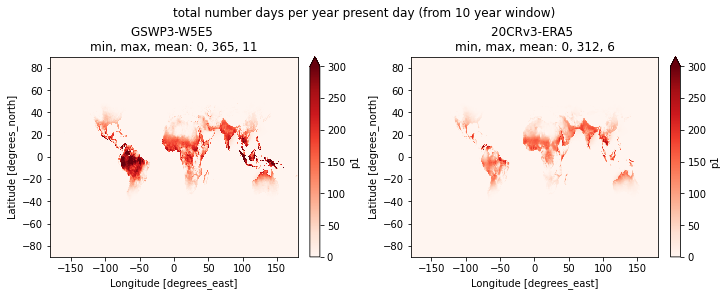

In [10]:
fig, axes = plt.subplots(1,2, figsize=(10,4),  layout='constrained')
axes = axes.flatten() 
vmax=300

for i,ax in zip(range(2), axes):
    data_plot= da_p1_obs_10y.isel(model=i)  * 365
    data_plot.plot(ax=ax, vmax=vmax, cmap='Reds')
    ax.set_title(f'{data_plot.model.values.item()} \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.0f}')

fig.suptitle('total number days per year present day (from 10 year window)');

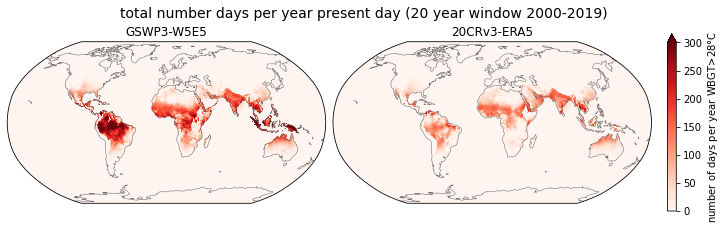

In [11]:

proj = ccrs.Robinson()
crs = ccrs.PlateCarree()
vmax=300
#nlevels=17
#cmap=make_mycmap_nowhite(cmap='RdBu_r', length=nlevels)
cmap='Reds'

fig, axes = plt.subplots(1,2, figsize=(10,3), layout='constrained', subplot_kw={'projection': proj})
axes = axes.flatten() 

for i,ax in zip(range(2), axes):
    data_plot= (da_p1_obs_20y.isel(model=i)  * 365)
    plot = data_plot.plot(ax=ax, vmax=vmax, transform=crs, cmap=cmap, add_colorbar=False)
    ax.set_title(f'{data_plot.model.values.item()}')
    ax.coastlines(color='dimgray', linewidth=0.5)

fig.suptitle('total number days per year present day (20 year window 2000-2019)',size=14);
plt.colorbar(plot, ax=ax, extend='max', label = 'number of days per year WBGT>28$\degree$C')
#plt.savefig(os.path.join(figdir,'wbgt_ndays_ISIMIP3a_obsclim.png'),dpi=300)

## 2. nAHD as difference in two obsclim periods (10, 20, 30 year) - WBGT28

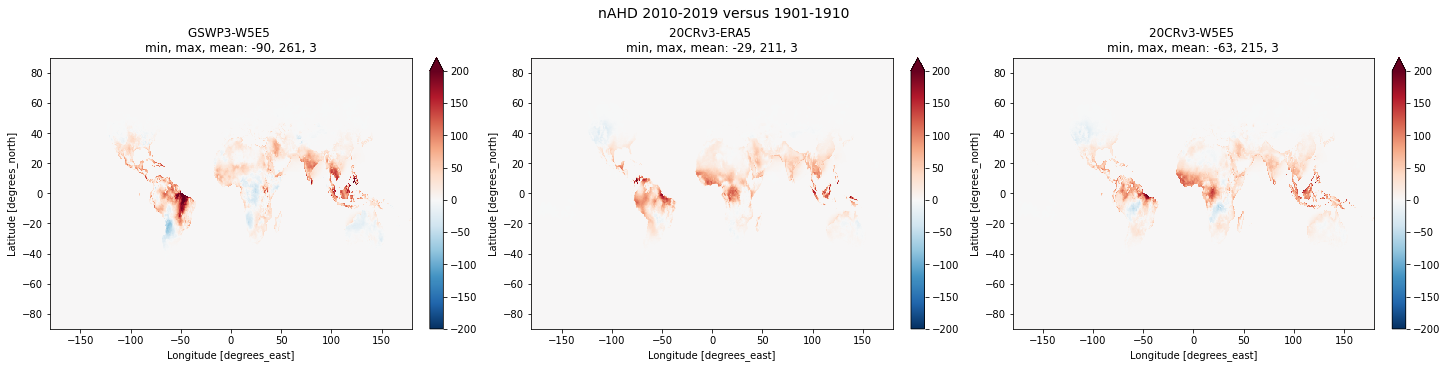

In [12]:
fig, axes = plt.subplots(1,3, figsize=(20,5), layout='constrained')
axes = axes.flatten() 
vmax=200

for i,ax in zip(range(3), axes):
    data_plot= da_nAHD_10y.isel(model=i)
    data_plot.plot(ax=ax, vmax=vmax)
    ax.set_title(f'{data_plot.model.values.item()} \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.0f}')

fig.suptitle('nAHD 2010-2019 versus 1901-1910',size=14);

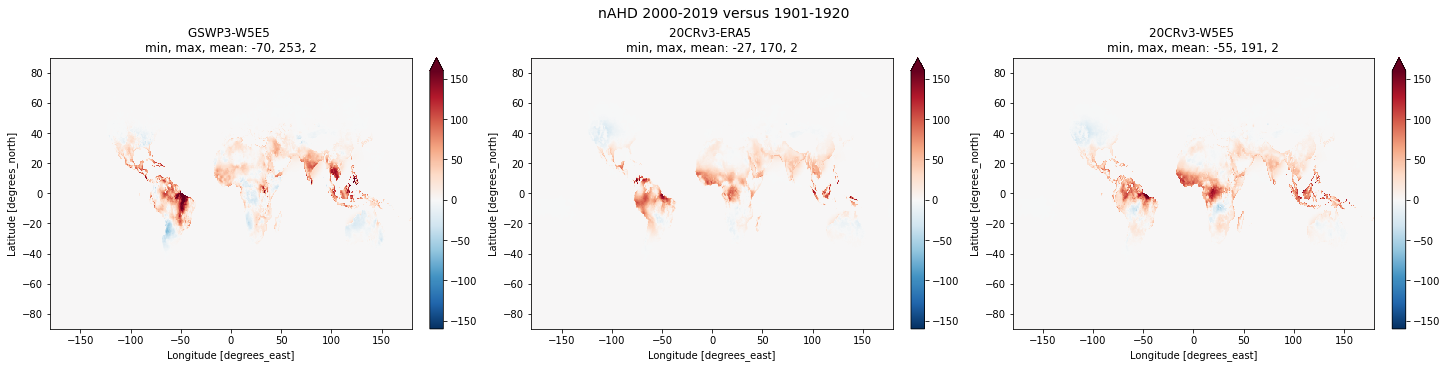

In [13]:
fig, axes = plt.subplots(1,3, figsize=(20,5), layout='constrained')
axes = axes.flatten() 
vmax=160

for i,ax in zip(range(3), axes):
    data_plot= da_nAHD_20y.isel(model=i)
    data_plot.plot(ax=ax, vmax=vmax)
    ax.set_title(f'{data_plot.model.values.item()} \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.0f}')

fig.suptitle('nAHD 2000-2019 versus 1901-1920',size=14);

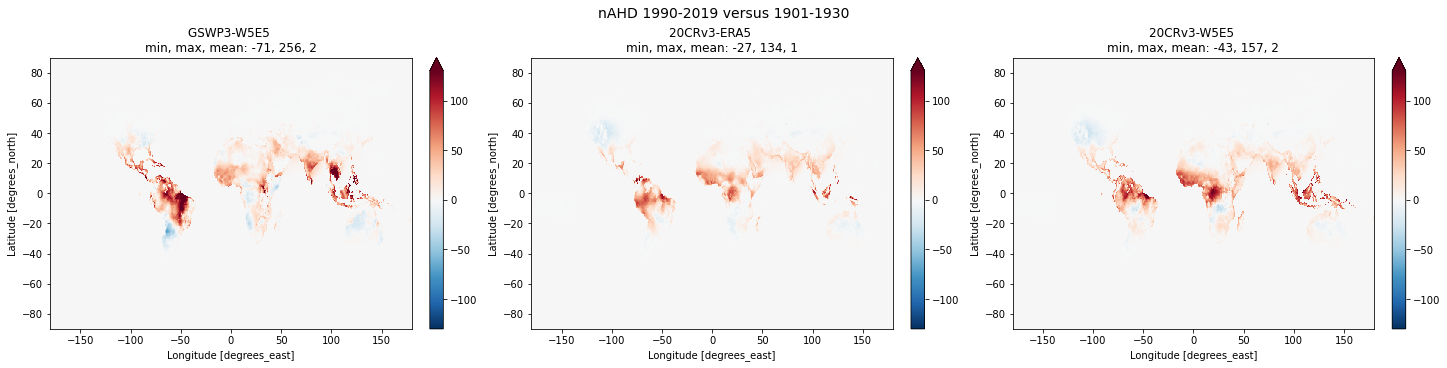

In [14]:
fig, axes = plt.subplots(1,3, figsize=(20,5), layout='constrained')
axes = axes.flatten() 
vmax=130

for i,ax in zip(range(3), axes):
    data_plot= da_nAHD_30y.isel(model=i)
    data_plot.plot(ax=ax, vmax=vmax)
    ax.set_title(f'{data_plot.model.values.item()} \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.0f}')

fig.suptitle('nAHD 1990-2019 versus 1901-1930',size=14);

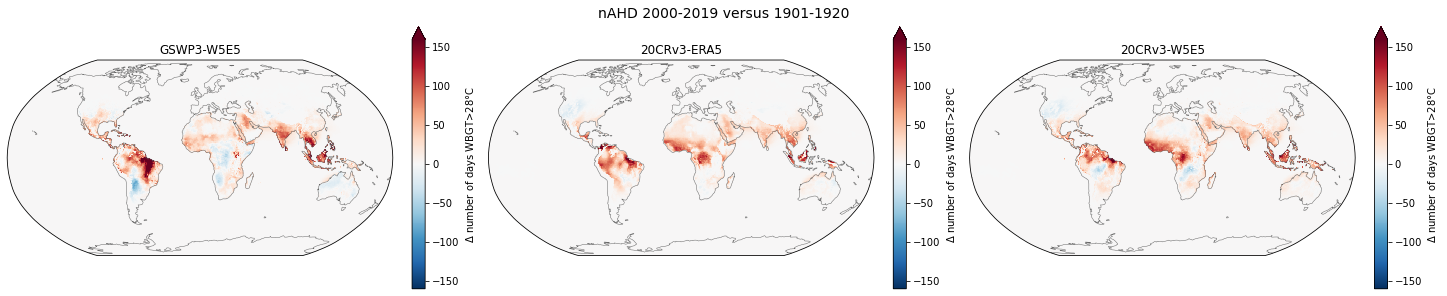

In [15]:

proj = ccrs.Robinson()
crs = ccrs.PlateCarree()
vmax=160
cmap='RdBu_r'

fig, axes = plt.subplots(1,3, figsize=(20,4), layout='constrained', subplot_kw={'projection': proj})
axes = axes.flatten() 

for i,ax in zip(range(3), axes):
    data_plot= da_nAHD_10y.isel(model=i).rename(
        '$\Delta$ number of days WBGT>28$\degree$C')
    data_plot.plot(ax=ax, vmax=vmax, transform=crs, cmap=cmap)
    ax.set_title(f'{data_plot.model.values.item()}')
    ax.coastlines(color='dimgray', linewidth=0.5)

fig.suptitle('nAHD 2000-2019 versus 1901-1920',size=14);
#plt.savefig(os.path.join(figdir,'wbgt_nAHD_ISIMIP3a_obsclim.png'),dpi=300)

## 3. counterclim v. obsclim

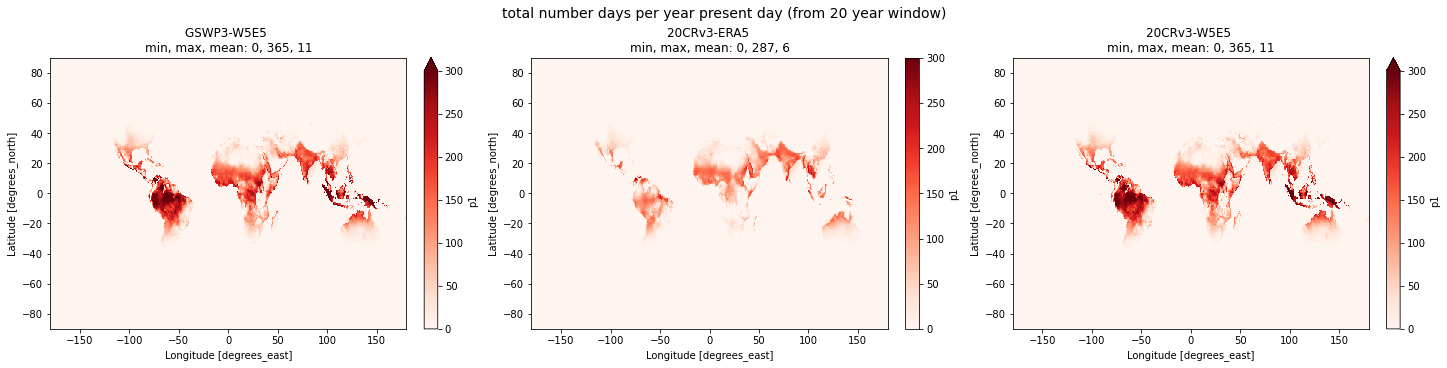

In [16]:
# obsclim

fig, axes = plt.subplots(1,3, figsize=(20,5), layout='constrained')
axes = axes.flatten() 
vmax=300

for i,ax in zip(range(3), axes):
    data_plot= da_p1_obs_20y.isel(model=i)  * 365
    data_plot.plot(ax=ax, vmax=vmax, cmap='Reds')
    ax.set_title(f'{data_plot.model.values.item()} \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.0f}')

fig.suptitle('total number days per year present day (from 20 year window)',size=14);

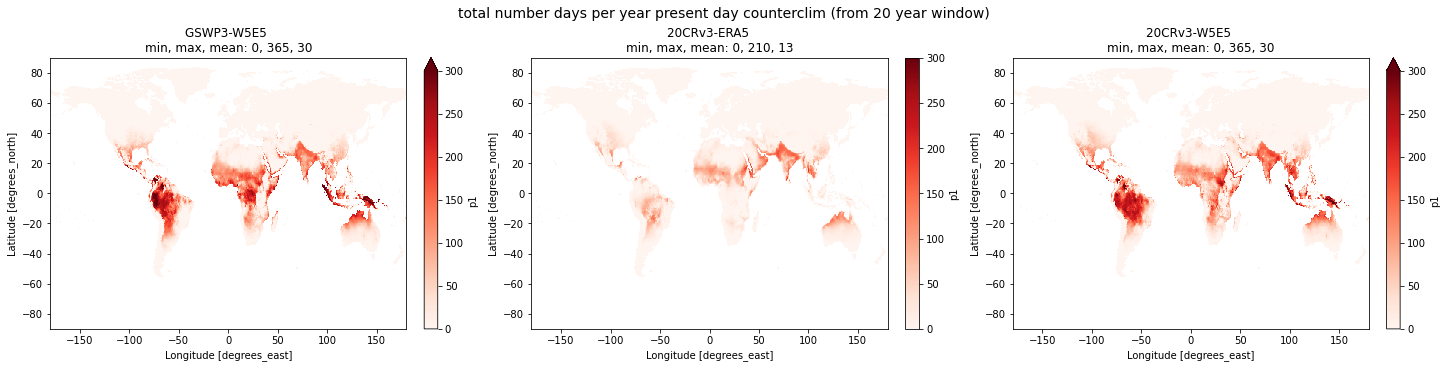

In [17]:
# counterclim days in present 

fig, axes = plt.subplots(1,3, figsize=(20,5), layout='constrained')
axes = axes.flatten() 
vmax=300

for i,ax in zip(range(3), axes):
    data_plot= da_p1_counterclim_20y.isel(model=i)  * 365
    data_plot.plot(ax=ax, vmax=vmax, cmap='Reds')
    ax.set_title(f'{data_plot.model.values.item()} \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.0f}')

fig.suptitle('total number days per year present day counterclim (from 20 year window)',size=14);


### Compare different ways of getting nAHD

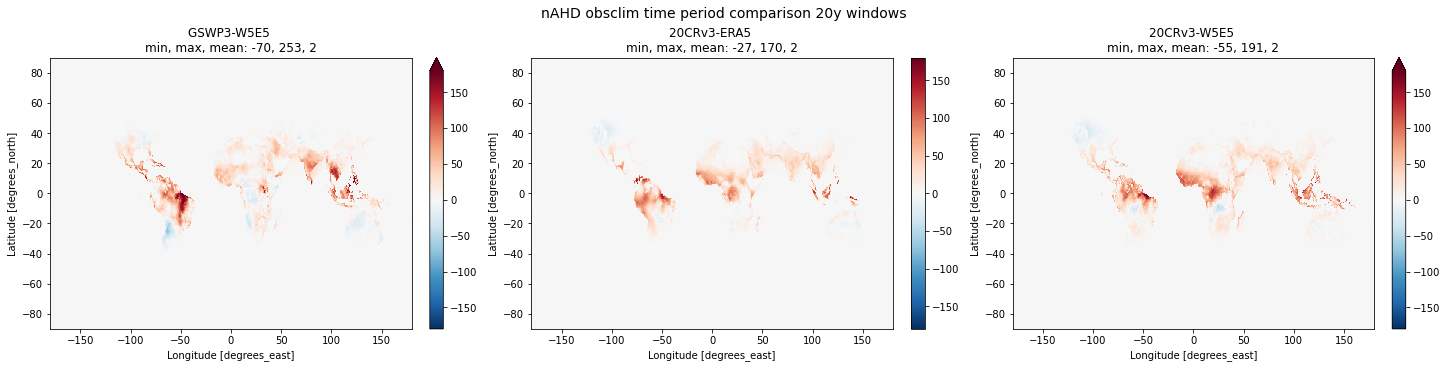

In [18]:
fig, axes = plt.subplots(1,3, figsize=(20,5), layout='constrained')
axes = axes.flatten() 
vmax=180

for i,ax in zip(range(3), axes):
    data_plot= da_nAHD_20y.isel(model=i)
    data_plot.plot(ax=ax, vmax=vmax)
    ax.set_title(f'{data_plot.model.values.item()} \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.0f}')

fig.suptitle('nAHD obsclim time period comparison 20y windows',size=14);

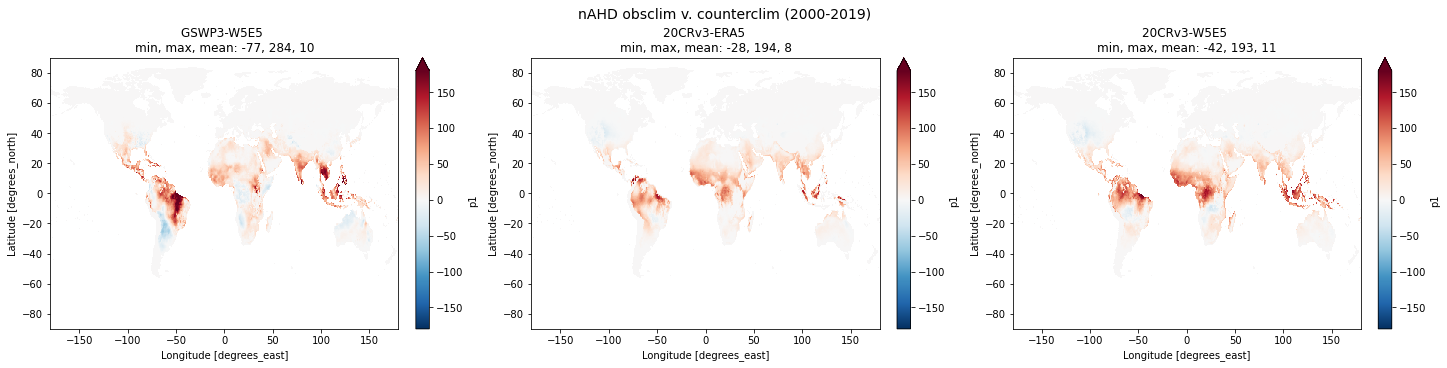

In [19]:
fig, axes = plt.subplots(1,3, figsize=(20,5), layout='constrained')
axes = axes.flatten() 
vmax=180

for i,ax in zip(range(3), axes):
    data_plot= da_nAHD_counterclim_20y.isel(model=i)
    data_plot.plot(ax=ax, vmax=vmax)
    ax.set_title(f'{data_plot.model.values.item()} \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.0f}')

fig.suptitle('nAHD obsclim v. counterclim (2000-2019)',size=14);

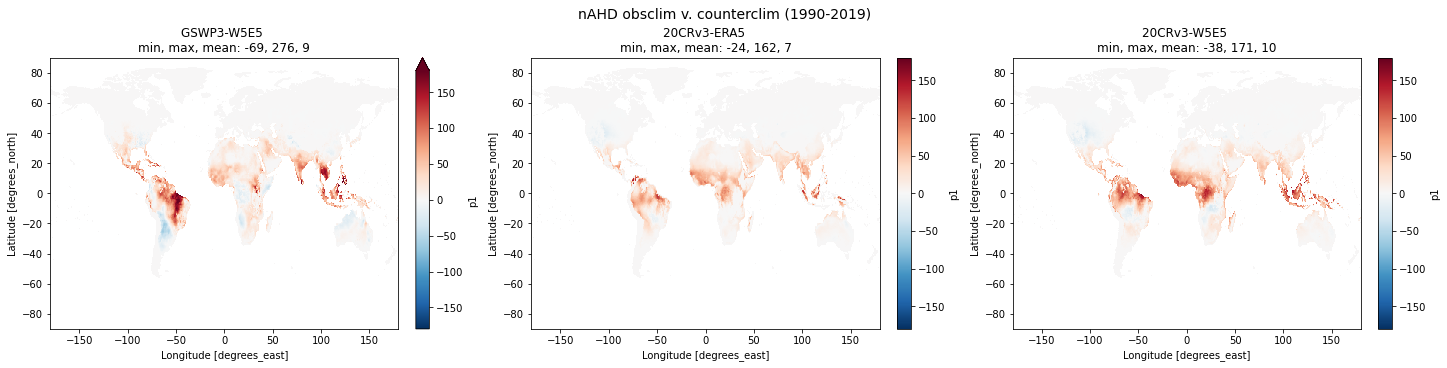

In [20]:
fig, axes = plt.subplots(1,3, figsize=(20,5), layout='constrained')
axes = axes.flatten() 
vmax=180

for i,ax in zip(range(3), axes):
    data_plot= da_nAHD_counterclim_30y.isel(model=i)
    data_plot.plot(ax=ax, vmax=vmax)
    ax.set_title(f'{data_plot.model.values.item()} \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.0f}')

fig.suptitle('nAHD obsclim v. counterclim (1990-2019)',size=14);

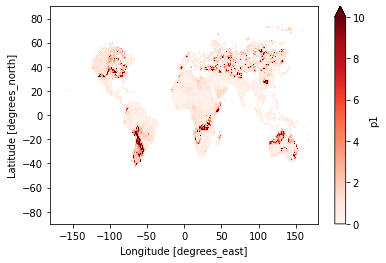

In [21]:
(da_nAHD_counterclim_30y.std(dim='model')/ np.abs(da_nAHD_counterclim_30y.mean(dim='model'))).plot(vmax=10,cmap='Reds')

# standard deviation between models (datasets), divided by mean
# coefficent of variance?

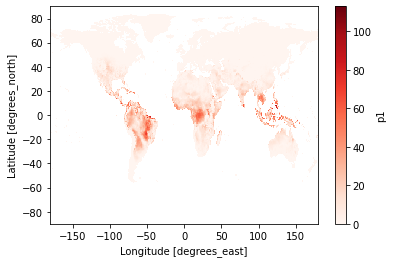

In [22]:
da_nAHD_counterclim_30y.std(dim='model').plot(cmap='Reds')

# variance between datasets 

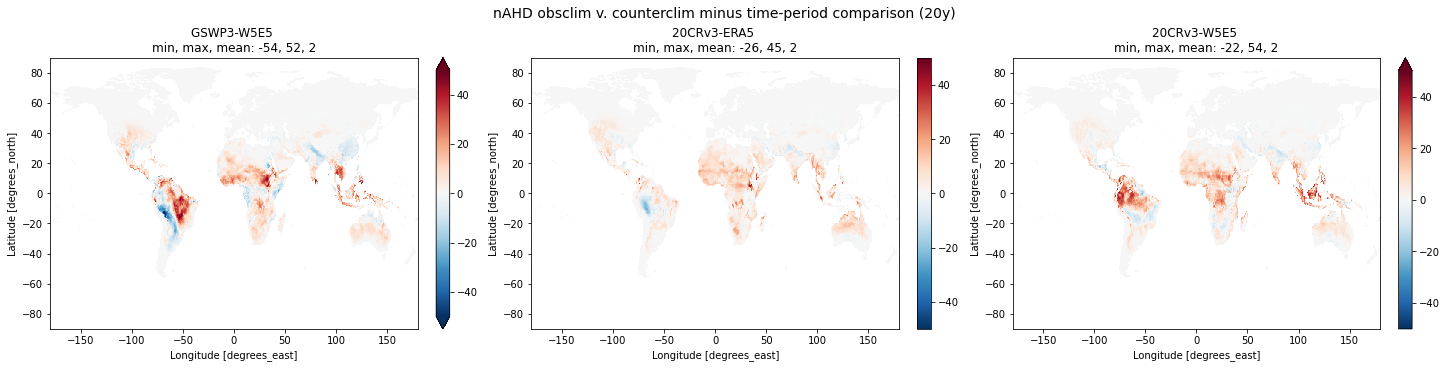

In [23]:
# compare comparing 2 time windows versus obsclim v. counterclim 


fig, axes = plt.subplots(1,3, figsize=(20,5), layout='constrained')
axes = axes.flatten() 
vmax=50

for i,ax in zip(range(3), axes):
    data_plot=  da_nAHD_counterclim_20y.isel(model=i) - da_nAHD_20y.isel(model=i)
    data_plot.plot(ax=ax, vmax=vmax)
    ax.set_title(f'{data_plot.model.values.item()} \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.0f}')

fig.suptitle('nAHD obsclim v. counterclim minus time-period comparison (20y)',size=14);

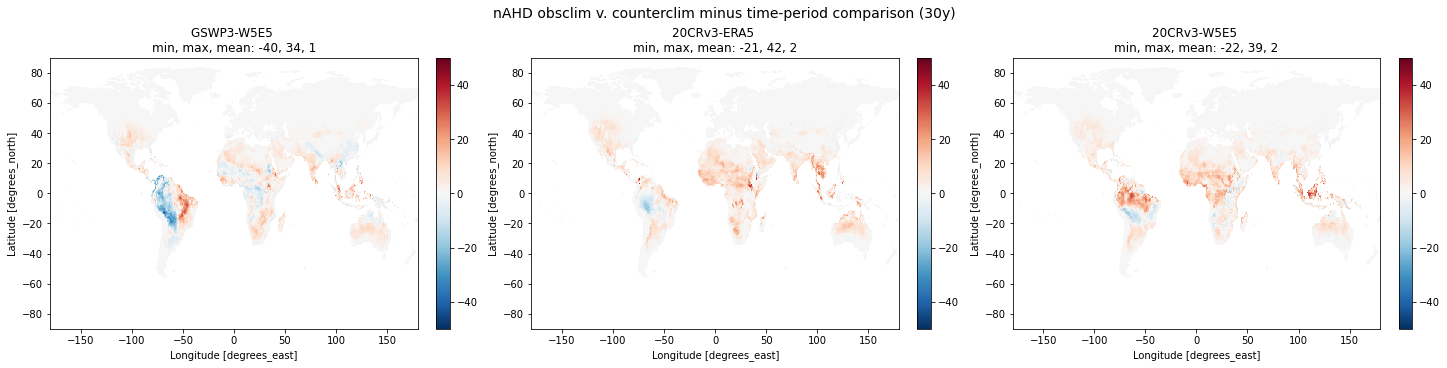

In [24]:
# compare comparing 2 time windows versus obsclim v. counterclim 


fig, axes = plt.subplots(1,3, figsize=(20,5), layout='constrained')
axes = axes.flatten() 
vmax=50

for i,ax in zip(range(3), axes):
    data_plot=  da_nAHD_counterclim_30y.isel(model=i) - da_nAHD_30y.isel(model=i)
    data_plot.plot(ax=ax, vmax=vmax)
    ax.set_title(f'{data_plot.model.values.item()} \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.0f}')

fig.suptitle('nAHD obsclim v. counterclim minus time-period comparison (30y)',size=14);

## combine with demographics

In [25]:
d_countries = preprocess_all_country_population_data()
gs_population_global = get_gridscale_population_global( 
    d_countries,
    startyear=2022,
    endyear=None,
    save=False # change where this gets saved !!!! now its in package folder
)

interpolating cohort sizes per country
after interpolation and mean-preserving correction there are some neg numbers in 10, Azerbaijan, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 98, Libya, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 136, Papua New Guinea, setting them to zero
Aruba small, population not calculated
Antigua and Barbuda small, population not calculated
Bahrain small, population not calculated
Barbados small, population not calculated
Federated States of Micronesia small, population not calculated
Grenada small, population not calculated
Guam small, population not calculated
Saint Lucia small, population not calculated
Macao small, population not calculated
Maldives small, population not calculated
Malta small, population not calculated
Singapore small, population not calculated
Tonga small, population not calculated
calculating gridscale population per cou

In [26]:
da_n_people_ndays_counterclim, da_prop_people_ndays_counterclim = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          datasets_sel, 
                                                                                          da_nAHD_counterclim_20y,  
                                                                                          x_hot_days = [1,5,10,20,50])

da_nAHD_percapita_peopledays_10y_counterclim = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                           datasets_sel, 
                                           da_nAHD_counterclim_20y,
                                           x_hot_days = [1, 5, 10, 20, 50], 
                                           ages_values=range(0,100),
                                           grouped = True,
                                           size_win = 10
                                           )

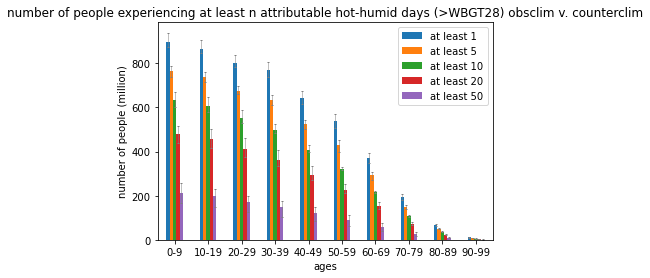

In [27]:
fig, ax = plt.subplots()
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays_counterclim, unit=1e6, year=2022, ax=ax, proportion=False)
plt.legend(labels = [f'at least {x}' for x in  [1, 5, 10, 20, 50]])
ax.set_title(f'number of people experiencing at least n attributable hot-humid days (>WBGT28) obsclim v. counterclim');

#plt.savefig(os.path.join(figdir,'n_atleastx_2022_10yr.png'),dpi=300)

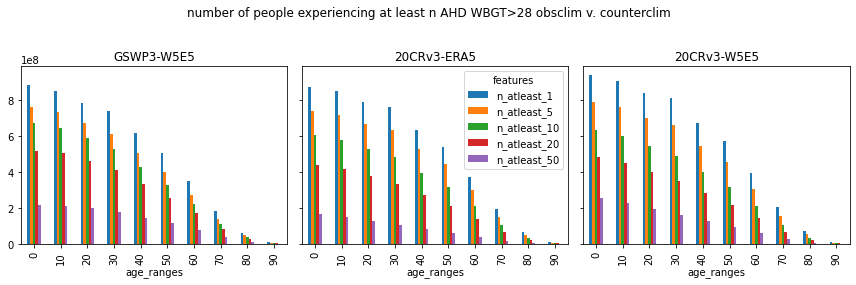

In [28]:
# number of people, TX90

fig, axes = plt.subplots(1,3,figsize=(12,4),sharex=True, sharey=True)
axes = axes.flatten()

for i, (dataset, ax) in enumerate(zip(datasets_sel, axes)):
    
    # make legend only appear on one subplot
    leg = True if i == 1 else False
    
    # plot 
    data_plot = da_n_people_ndays_counterclim.sel(model=dataset)
    data_plot.to_pandas().plot.bar(ax=ax, legend=leg)
    ax.set_title(f'{da_n_people_ndays_counterclim.model[i].values}')

    
fig.suptitle('number of people experiencing at least n AHD WBGT>28 obsclim v. counterclim\n', size=12)
fig.tight_layout()

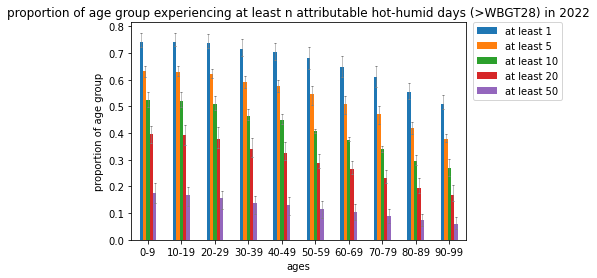

In [29]:
fig, ax = plt.subplots()
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays_counterclim, unit=1, year=2022, ax=ax, proportion=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, labels = [f'at least {x}' for x in  [1, 5, 10, 20, 50]])
ax.set_title(f'proportion of age group experiencing at least n attributable hot-humid days (>WBGT28) in 2022');

#plt.savefig(os.path.join(figdir,'prop_atleastx_2022_10yr.png'),dpi=300)

In [30]:
df_percapitadays_10y = da_nAHD_percapita_peopledays_10y_counterclim.sel(features='per_capita_days').to_pandas().T
df_percapitadays_10y.round(2) #.applymap(format_large_numbers)

model,GSWP3-W5E5,20CRv3-ERA5,20CRv3-W5E5
age_ranges,,,
0,24.74,20.33,25.04
10,25.05,19.86,24.08
20,24.98,19.06,22.65
30,22.83,17.35,20.17
40,22.31,16.68,19.29
50,20.17,15.33,17.37
60,18.85,14.07,15.86
70,16.68,12.38,13.89
80,14.86,10.43,11.50


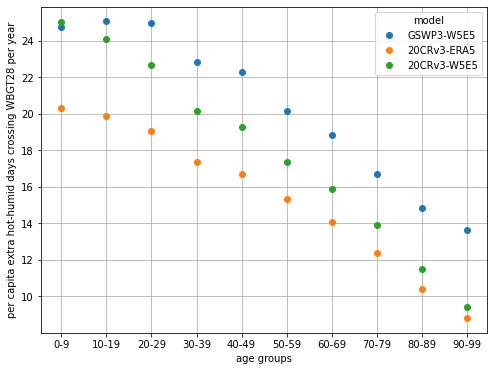

In [31]:
fig, ax = plt.subplots(figsize=(8,6))
df_plot = df_percapitadays_10y
df_plot.plot(marker='o',linestyle='None', ax=ax)
plt.ylabel(f'per capita extra hot-humid days crossing WBGT28 per year')
plt.xlabel('age groups')
plt.xticks(df_plot.index);
plt.grid()
ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+9}' for x in df_plot.index], rotation='horizontal');

# much smaller signal than from models !! 

## Open Delhi and Calcutta pixels 

In [32]:
lat_d, lon_d = 28,77
lat_c, lon_c = 22,88

# obsclim compare 20 or 30 year periods 
da_nAHD_10y_delhi = da_nAHD_10y.sel(lat=lat_d, lon=lon_d, method='nearest')
da_nAHD_10y_calcutta = da_nAHD_10y.sel(lat=lat_c, lon=lon_c, method='nearest')

da_nAHD_20y_delhi = da_nAHD_20y.sel(lat=lat_d, lon=lon_d, method='nearest')
da_nAHD_20y_calcutta = da_nAHD_20y.sel(lat=lat_c, lon=lon_c, method='nearest')

da_nAHD_30y_delhi = da_nAHD_30y.sel(lat=lat_d, lon=lon_d, method='nearest')
da_nAHD_30y_calcutta = da_nAHD_30y.sel(lat=lat_c, lon=lon_c, method='nearest')

# obsclim v. counterclim 
da_nAHD_counterclim_10y_delhi = da_nAHD_counterclim_10y.sel(lat=lat_d, lon=lon_d, method='nearest')
da_nAHD_counterclim_10y_calcutta = da_nAHD_counterclim_10y.sel(lat=lat_c, lon=lon_c, method='nearest')

da_nAHD_counterclim_20y_delhi = da_nAHD_counterclim_20y.sel(lat=lat_d, lon=lon_d, method='nearest')
da_nAHD_counterclim_20y_calcutta = da_nAHD_counterclim_20y.sel(lat=lat_c, lon=lon_c, method='nearest')

da_nAHD_counterclim_30y_delhi = da_nAHD_counterclim_30y.sel(lat=lat_d, lon=lon_d, method='nearest')
da_nAHD_counterclim_30y_calcutta = da_nAHD_counterclim_30y.sel(lat=lat_c, lon=lon_c, method='nearest')


In [38]:
print('Delhi based on 2 periods of obsclim')

pd.concat(
    [da_nAHD_30y_delhi.isel(time=0).to_pandas(),
    da_nAHD_20y_delhi.isel(time=0).to_pandas(),
    da_nAHD_10y_delhi.isel(time=0).to_pandas()],
    axis=1,
    keys=['30y', '20y', '10y']
).applymap(format_large_numbers)


# based on 2 time periods of obsclim (1901 - 1901+period, 2019-period - 2019)

Delhi based on 2 periods of obsclim


,30y,20y,10y
model,,,
GSWP3-W5E5,22.0,38.9,52.3
20CRv3-ERA5,11.2,19.0,23.1
20CRv3-W5E5,9.8,19.3,27.1


In [39]:
print('Delhi based on obsclim v. counterclim')

pd.concat(
    [da_nAHD_counterclim_30y_delhi.isel(time=0).to_pandas(),
    da_nAHD_counterclim_20y_delhi.isel(time=0).to_pandas(),
    da_nAHD_counterclim_10y_delhi.isel(time=0).to_pandas()],
    axis=1,
    keys=['30y', '20y', '10y']
).applymap(format_large_numbers)

# obsclim versus counterclim - Delhi

Delhi based on obsclim v. counterclim


,30y,20y,10y
model,,,
GSWP3-W5E5,16.7,18.3,19.2
20CRv3-ERA5,11.4,12.7,14.6
20CRv3-W5E5,13.9,14.6,13.5


In [40]:
print('Calcutta based on 2 periods of obsclim')

pd.concat(
    [da_nAHD_30y_calcutta.isel(time=0).to_pandas(),
    da_nAHD_20y_calcutta.isel(time=0).to_pandas(),
    da_nAHD_10y_calcutta.isel(time=0).to_pandas()],
    axis=1,
    keys=['30y', '20y', '10y']
).applymap(format_large_numbers)

Calcutta based on 2 periods of obsclim


,30y,20y,10y
model,,,
GSWP3-W5E5,38.4,48.6,43.0
20CRv3-ERA5,26.9,29.8,31.1
20CRv3-W5E5,8.6,9.4,-1.2


In [41]:
print('Calcutta based on obsclim v. counterclim')

pd.concat(
    [da_nAHD_counterclim_30y_calcutta.isel(time=0).to_pandas(),
    da_nAHD_counterclim_20y_calcutta.isel(time=0).to_pandas(),
    da_nAHD_counterclim_10y_calcutta.isel(time=0).to_pandas()],
    axis=1,
    keys=['30y', '20y', '10y']
).applymap(format_large_numbers)

Calcutta based on obsclim v. counterclim


,30y,20y,10y
model,,,
GSWP3-W5E5,38.5,41.0,45.6
20CRv3-ERA5,34.9,37.2,36.4
20CRv3-W5E5,10.3,9.9,10.7
